## Week 7-1: MCMC and Bayesian high-dimensional analysis


#### Announcement

* Forgot about the learning rate in Newton's method?
$
\beta^{(t+1)} = \beta^{(t)} - \color{red}{s} \Big\{\Big( \frac{\partial^2 \ell(\beta)}{\partial \beta \partial \beta'} \Big)^{-1} \frac{\partial \ell(\beta)}{\partial \beta} \Big\} \Big|_{\beta = \beta^{(t)}}
$


#### Last time
* Gibbs sampling

#### Today
* Convergence diagnostics for MCMC
* Metroplis-Hastings algorithm
* Bayesian high-dimensional analysis

#### Reference

_MCMC_
* (__TBC__) Robert, C. P. (1994). The Bayesian Choice. 2nd Edition. _Springer Text in Statistics_.
* Christophe Andrieu, Arnaud Doucet, and Roman Holenstein (2010). Particle Markov chain Monte Carlo methods. _JRSSB_ 72: 269--342
* Vivekananda Roy (2019). Convergence diagnostics for Markov chain Monte Carlo [link](https://arxiv.org/pdf/1909.11827.pdf)
* Pierre Jacob, O’Leary, and Atchadé (2020). Unbiased Markov chain Monte Carlo methods withcouplings. _JRSSB_ 82:543--600
* pymc-learn: https://pymc-learn.readthedocs.io/en/latest/
* PyStan: https://pystan.readthedocs.io/en/latest/index.html
* Stan: https://mc-stan.org/

_Bayesian high-dimensinal analysis_
* A. Bhada, J. Datta, N. Polson, and B. Willard (2019). Lasso Meets Horseshoe: A Survey. _Statistical Science_ 34:405--427
* R. Bai, V. Rockova, and E. Geroge (2021): Spike-and-Slab Meets LASSO: A Review of the Spike-and-Slab LASSO. arXiv:2010.06451
* I. Castillo, J. Schmidt-Hieber, and A. van der Vaart (2015). Bayesian linear regression with sparse priors. _AOS_ 43:1986--2018
* E. George and R. McCulloch (1993). Variable Selection via Gibbs Sampling. _JASA_ 88:881-889.
* V. Rockova and E. George (2018). The Spike-and-Slab LASSO. _JASA_ 113:431--444
* R. Martin, R. Mess, and S. Walker (2017). Empirical Bayes posterior concentration in sparse high-dimensional linear models. _Bernoulli_ 23:1822--1847

Bayesian machine learning is a paradigm for constructing statistical models based on Bayes’ Theorem.

_Bayes' theorem_
$$
\pi(\theta | x) = \frac{f(x | \theta) \pi(\theta)}{\int f(x | \theta) \pi(\theta) d\theta}
$$

- $\pi(\theta|x)$: posterior distribution
- $f(x | \theta)$: likelihood function
- $\pi(\theta)$: prior distribution

### Gibbs sampling

Suppose we want to simulate $\alpha, \beta, \gamma$ from their joint posterior distribution $\pi(\alpha, \beta, \gamma | x)$. Suppose it is "easy" to simulate from their conditional distributions $\pi(\alpha | \beta, \gamma, x)$, 
$\pi(\beta | \alpha, \gamma, x)$, $\pi(\gamma | \alpha, \beta, x)$, then the Gibbs sampling follows:

- Step 0: Start with initial values $\alpha^{(0)}$, $\beta^{(0)}$, and $\gamma^{(0)}$
- Step 1 to Step $T$: repeat ($t = 1, \dots, T$)
    - draw $\alpha^{(t)}$ from $\pi(\alpha | \beta^{(t-1)}, \gamma^{(t-1)}, x)$
    - draw $\beta^{(t)}$ from $\pi(\beta | \alpha^{(t)}, \gamma^{(t-1)}, x)$
    - draw $\gamma^{(t)}$ from $\pi(\gamma | \alpha^{(t)}, \beta^{(t)}, x)$
- Stop when $T$ is large enough    


_Example 1:_ Consider the model $x_i \sim N(\mu, \sigma^2)$, $i=1,\dots,n$ and $x_i$ are i.i.d., both $\mu$ and $\sigma^2$ are unknown. Priors are $\mu|\sigma^2 \sim N(0, \sigma^2)$ and $\sigma^{-2} \sim \text{Gamma}(1, 1)$, then the posterior distributions are 

$$\pi(\mu | \sigma^2, x^n) = N\Bigg(\frac{\sum_{i=1}^n x_i}{n+1}, \frac{\sigma^2}{n+1}\Bigg)$$
$$\pi(\sigma^{-2} | \mu, x^n) = \text{Gamma}\Bigg(\frac{n}{2}+1, \sum_{i=1}^n \frac{(x_i - \mu)^2}{2} + 1\Bigg)$$



In [1]:
import numpy as np
np.random.seed(2022)

# generate the dataset
N = 100
mu_true = 1
sigsq_true = 2
x = np.random.normal(mu_true, np.sqrt(sigsq_true), N)

In [2]:
# run gibbs sampling
T = 5000 # total iterations
mu0 = 5 # initial values
sigsq0 = 10

mu_draws = sigsq_draws = [] # create empty arrays for collecting draws
for t in range(T) :
    if t == 0:
        mu = mu0
    
    sigsq = 1/np.random.gamma(N/2 + 1, 1/(sum((x - mu)**2)/2 + 1), 1) 
        # draw sigma from its conditional posterior dist.
    mu = np.random.normal(sum(x)/(N+1), sigsq/(N+1), 1) 
        # draw mu from its conditional posterior dist.
    mu_draws = np.append(mu_draws, mu) # collect draws
    sigsq_draws = np.append(sigsq_draws, sigsq)

#### Convergence diagnose for $\mu$

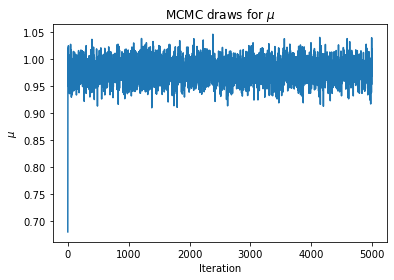

In [3]:
from matplotlib import pyplot as plt

plt.title("MCMC draws for $\mu$") 
plt.xlabel("Iteration") 
plt.ylabel("$\mu$")
plt.plot(mu_draws)


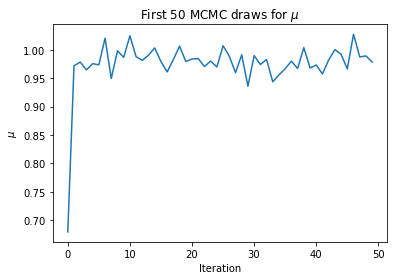

In [4]:
# take closer look at the first 50 draws
from matplotlib import pyplot as plt

plt.title("First 50 MCMC draws for $\mu$") 
plt.xlabel("Iteration") 
plt.ylabel("$\mu$")
plt.plot(mu_draws[range(50)])

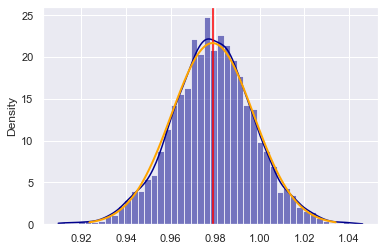

In [5]:
# histogram and density plot of draws

import seaborn as sns
import scipy.stats as stats
sns.set_theme(style="darkgrid")

burnin = int(T * 0.2)
mu_draws_mean = np.mean(mu_draws[burnin:T])
sns.histplot(mu_draws[burnin:T], kde=True, stat = "density", color = 'darkblue')
plt.axvline(mu_draws_mean, color = "red")

# add theoretical normal density
norm_mean = mu_draws_mean
norm_std = np.std(mu_draws[burnin:T])
points = np.linspace(norm_mean - 3*norm_std, norm_mean + 3*norm_std, 100)
plt.plot(points, stats.norm.pdf(points, norm_mean, norm_std), color = "orange", linewidth = 2)

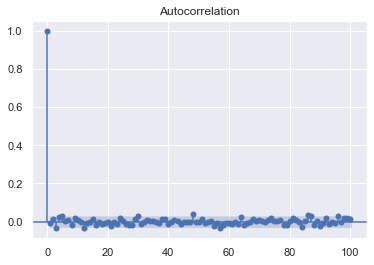

In [6]:
# plot autocorrelation function 
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(mu_draws[burnin:T], lags=100); # add ; otherwise, give two plots

#### Convergence diagnose for $\sigma$

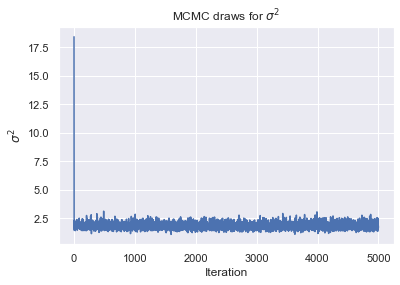

In [7]:
from matplotlib import pyplot as plt

plt.title("MCMC draws for $\sigma^2$") 
plt.xlabel("Iteration") 
plt.ylabel("$\sigma^2$")
plt.plot(sigsq_draws)


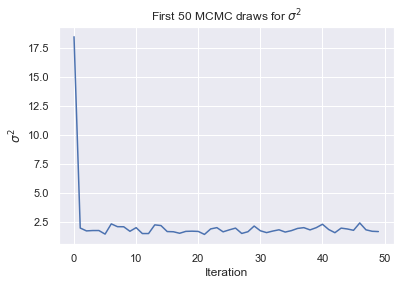

In [8]:
# take a look at the first 50 draws
from matplotlib import pyplot as plt

plt.title("First 50 MCMC draws for $\sigma^2$") 
plt.xlabel("Iteration") 
plt.ylabel("$\sigma^2$")
plt.plot(sigsq_draws[range(50)])


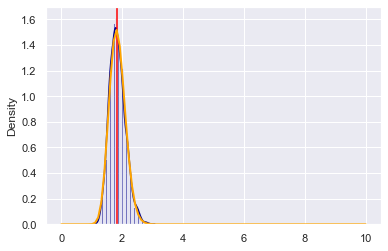

In [9]:
# histogram and density plot of draws

import seaborn as sns
import scipy.stats as stats 
sns.set_theme(style="darkgrid")

burnin = int(T * 0.2)
sigsq_draws_mean = np.mean(sigsq_draws[burnin:T])
sns.histplot(sigsq_draws[burnin:T], stat = "density", kde=True, color = 'darkblue')
plt.axvline(sigsq_draws_mean, color = "red")


# add theoretical gamma density
gamma_mean = np.mean(sigsq_draws[burnin:T])
gamma_var = np.var(sigsq_draws[burnin:T])
gamma_scale = gamma_var / gamma_mean # get scale para
gamma_shape = gamma_mean / gamma_scale # get shape para

# points = (np.linspace(gamma_mean+0.0001, 15, 100) - gamma_mean)/gamma_scale
# plt.plot(points, gamma.pdf(points, gamma_shape), color = "orange", linewidth = 2)

points = np.linspace(0.0001, 10, 100)
plt.plot(points, stats.gamma.pdf(points, a = gamma_shape, scale = gamma_scale), color = "orange", linewidth = 2)

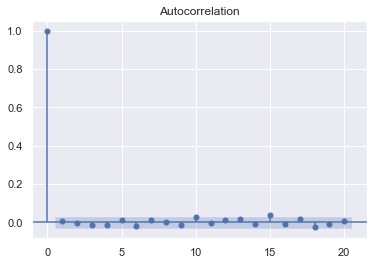

In [10]:
# plot autocorrelation function 
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(sigsq_draws[burnin:T], lags=20); # add ; otherwise, give two plots

_Q: How to obtain the credible intervals for $\theta$ and $\sigma^2$?_

### Metroplis-Hastings


What if simulating from the conditional posterior distribution is not easy. For example, my client strongly believe the prior of $\theta$ should be a Laplace density (not normal). Thus, the prior is no longer conjugate with the likelihood function. (We will see that a Laplace density is used for Bayesian high-dimensional analysis in the next lecture.) One can use the Metropolis-Hastings algorithm. 

The M-H algorithm first random draw a sample from a proposal density, say $\theta^\star \sim q(\theta| \theta^{(t)})$, then compute the acceptance probability: 
$$
\alpha(\theta^\star, \theta^{(t)}) = \frac{\pi(\theta^\star) q(\theta^{(t)}|\theta^\star)}{\pi(\theta^{(t)}) q(\theta^\star|\theta^{(t)})}
$$

- Let $\theta^{(t+1)} = \theta^\star$ with probability $\rho = \min\{\alpha(\theta^\star, \theta^{(t)}), 1\}$
- Let $\theta^{(t+1)} = \theta^{(t)}$ with probability $1-\rho$

In practice, draw $u \sim \text{Uniform}(0, 1)$:
- if $u \leq \rho$, $\theta^{(t+1)} = \theta^\star$
- if $u > \rho$, $\theta^{(t+1)} = \theta^{(t)}$


_Example:_ Consider the model $x_i \sim N(\mu, \sigma^2)$, $i=1,\dots,n$ and $x_i$ are i.i.d., both $\mu$ and $\sigma^2$ are unknown. Priors are $\mu \sim \text{Laplace}(0, 1)$ and $\sigma^{-2} \sim \text{Gamma}(1, 1)$, then the  posterior distributions are 

- $\pi(\mu | \sigma^2, x^n) \propto \prod_{i=1}^n N(x_i | \mu, \sigma^2) \times \text{Laplace}(0, 1)$
- $\pi(\sigma^{-2} | \mu, x^n) = \text{Gamma}\Big(\frac{n}{2}+1, \frac{\sum_{i=1}^n (x_i - \mu)^2}{2} + 1\Big)$

We choose the proposal density for $\mu \sim N(\mu^{(t)}, 1)$, centered at the previous draw of $\mu^{(t)}$, then $N(\mu | \mu^{(t)}, 1) = N(\mu^{(t)} | \mu, 1)$, thus the acceptance probability simply becomes 
$$
\alpha(\mu^\star, \mu^{(t)}) = \frac{\pi(\mu^\star| \sigma^2, x^n)}{\pi(\mu^{(t)} | \sigma^2, x^n)}
= \exp\Big( 
\log \pi(\mu^\star| \sigma^2, x^n) - \log \pi(\mu^{(t)} | \sigma^2, x^n)
\Big)
$$

By plugging-in the expression of $\pi(\mu | \sigma^2, x^n)$, we obtain 
\begin{align}
\log \pi(\mu| \sigma^2, x^n) - \log \pi(\mu^{(t)} | \sigma^2, x^n)
& = - \frac{\sum_{i=1}^n (x_i - \mu)^2 - \sum_{i=1}^n (x_i - \mu^{(t)})^2}{2\sigma^2} - |\mu| + |\mu^{(t)}|\\
& = - \frac{n \mu^2 - n \big(\mu^{(t)}\big)^2 - 2\sum_{i=1}^n x_i(\mu - \mu^{(t)})}{2\sigma^2} - |\mu| + |\mu^{(t)}|
\end{align}

We still choose $\sigma^{-2} \sim \text{Gamma}(1, 1)$, so the conditional posterior distribution of $\sigma^2$ given $\mu, x^n$ stays the same

In [11]:
# run gibbs sampling
T = 10000 # total iterations
mu0 = 5 # initial values
sigsq0 = 2
accpt_count = 0 # count number of accepted draws

mu_draws = sigsq_draws = [] # create empty arrays for collecting draws
for t in range(T) :
    if t == 0:
        mu = mu0
    
    sigsq = 1/np.random.gamma(N/2 + 1, 1/(sum((x - mu)**2)/2 + 1), 1) 
        # draw sigma from its conditional posterior dist.
    mu_prop = np.random.normal(mu, 0.2)
    neg_log_alpha = (N*(mu_prop**2 - mu**2) - 2*sum(x)*(mu_prop - mu))/(2*sigsq) + abs(mu_prop) - abs(mu)
    alpha = np.exp(-neg_log_alpha)
    
    # draw u ~ Unif([0,1])
    u = np.random.uniform(0, 1)
    
    if u < alpha:
        mu = mu_prop
        accpt_count = accpt_count + 1
    else:
        mu = mu

    mu_draws = np.append(mu_draws, mu) # collect draws
    sigsq_draws = np.append(sigsq_draws, sigsq)

In [12]:
# check the number of draws accepted
# here in order to obtain a reasonable acceptance ratio, the proposal density needs to be chosen smartly. 
# A bad proposal density can lead to a small acceptance ratio. Then the algorithm will "stuck" in a certain value of 
# theta for a long period
# here, you can try to change the proposal density to $N(mu, 1)$ or $N(mu, 10)$ or $N(mu, 0.1)$. 
accpt_ratio = accpt_count/T
print(accpt_ratio)

0.5924


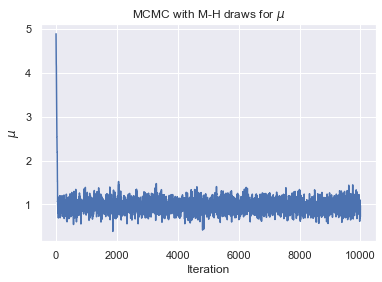

In [13]:
from matplotlib import pyplot as plt

plt.title("MCMC with M-H draws for $\mu$") 
plt.xlabel("Iteration") 
plt.ylabel("$\mu$")
plt.plot(mu_draws)

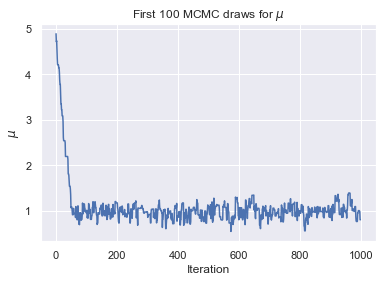

In [14]:
# take closer look at the first 50 draws
from matplotlib import pyplot as plt

plt.title("First 100 MCMC draws for $\mu$") 
plt.xlabel("Iteration") 
plt.ylabel("$\mu$")
plt.plot(mu_draws[range(1000)])

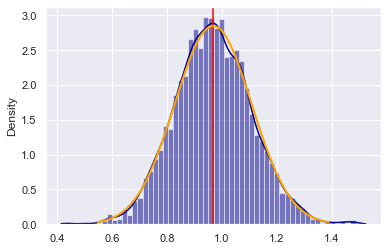

In [15]:
# histogram and density plot of draws

import seaborn as sns
import scipy.stats as stats
sns.set_theme(style="darkgrid")

burnin = int(T * 0.2)
mu_draws_mean = np.mean(mu_draws[burnin:T])
sns.histplot(mu_draws[burnin:T], kde=True, stat = "density", color = 'darkblue')
plt.axvline(mu_draws_mean, color = "red")

# add theoretical normal density
norm_mean = mu_draws_mean
norm_std = np.std(mu_draws[burnin:T])
points = np.linspace(norm_mean - 3*norm_std, norm_mean + 3*norm_std, 100)
plt.plot(points, stats.norm.pdf(points, norm_mean, norm_std), color = "orange", linewidth = 2)

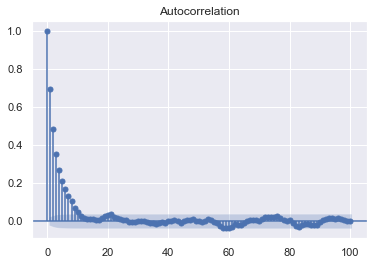

In [16]:
# plot autocorrelation function 
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(mu_draws[burnin:T], lags=100); # add ; otherwise, give two plots

#### Convergence for $\sigma^2$

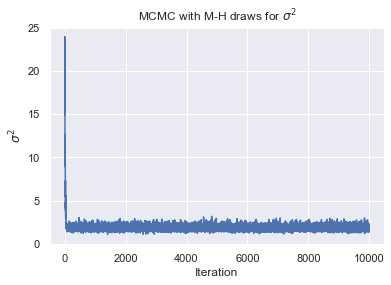

In [17]:
from matplotlib import pyplot as plt

plt.title("MCMC with M-H draws for $\sigma^2$") 
plt.xlabel("Iteration") 
plt.ylabel("$\sigma^2$")
plt.plot(sigsq_draws)


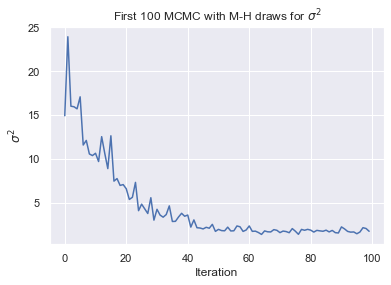

In [18]:
# take a look at the first 50 draws
from matplotlib import pyplot as plt

plt.title("First 100 MCMC with M-H draws for $\sigma^2$") 
plt.xlabel("Iteration") 
plt.ylabel("$\sigma^2$")
plt.plot(sigsq_draws[range(100)])


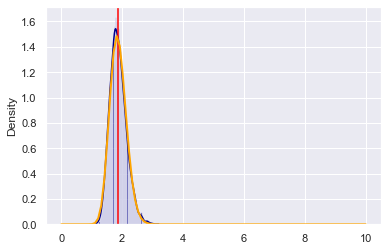

In [19]:
# histogram and density plot of draws

import seaborn as sns
import scipy.stats as stats 
sns.set_theme(style="darkgrid")

burnin = int(T * 0.2)
sigsq_draws_mean = np.mean(sigsq_draws[burnin:T])
sns.histplot(sigsq_draws[burnin:T], stat = "density", kde=True, color = 'darkblue')
plt.axvline(sigsq_draws_mean, color = "red")


# add theoretical gamma density
gamma_mean = np.mean(sigsq_draws[burnin:T])
gamma_var = np.var(sigsq_draws[burnin:T])
gamma_scale = gamma_var / gamma_mean # get scale para
gamma_shape = gamma_mean / gamma_scale # get shape para

# points = (np.linspace(gamma_mean+0.0001, 15, 100) - gamma_mean)/gamma_scale
# plt.plot(points, gamma.pdf(points, gamma_shape), color = "orange", linewidth = 2)

points = np.linspace(0.0001, 10, 100)
plt.plot(points, stats.gamma.pdf(points, a = gamma_shape, scale = gamma_scale), color = "orange", linewidth = 2)

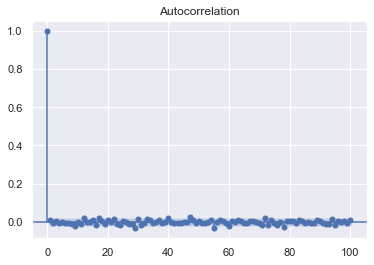

In [20]:
# plot autocorrelation function 
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(sigsq_draws[burnin:T], lags=100); # add ; otherwise, give two plots

#### Comments:

1. Perhaps the biggest issue is determining how many steps to stop. In theory, the method provides consistent approximations if the number of iterative goes to infinity. In practice, we have to stop at some point. When to stop the algorithm is often problem-specific. One needs to run convergence diagnoses to check the convergence of chains. 
2. MCMC is lesser sensitive to the initial choice of parameters (compared to the other methods mentioned in this class, e.g., gradient descent). But a bad starting point can lead to a longer time to converge and a lower acceptance rate for the M-H algorithm.
3. There are many other sampling-based methods, including reversible jump mcmc, importance sampling, Hamiltonian Monte Carlo, particle MCMC (Andrieu, Doucet, and Holenstein, 2010), sequential Monte Carlo, and slice sampling. Due to time constraints, we could not cover them in the class.
4. MCMC is an iterative method, so it is difficult for parallel computing implementation. A recent work by Jacob et al. using couplings idea is very promising to conduct parallel computing for MCMC. (see Pierre Jacob, O’Leary, and Atchadé (2020); or watch [this](https://www.youtube.com/watch?v=ohu8DJ1qDb0&t=3995s))
5. [pymc-learn](https://pymc-learn.readthedocs.io/en/latest/), [Stan](https://mc-stan.org/) or [PyStan](https://pystan.readthedocs.io/en/latest/index.html) are commonly used package for running MCMC by pratitioners. 

### Bayesian high-dimensional analysis

Consider the high-dimensional linear regression model 
$$
Y = X\beta + \varepsilon, 
$$
where $Y = (y_1, \dots, y_n)' \in \mathbb{R}^n$, $X \in \mathbb{R}^{n \times p}$, $\beta \in \mathbb{R}^p$, $\varepsilon \sim N(0, \sigma^2 I_n)$, and $p \gg n$.

A Bayesian imposes sparsity on $\beta$ through a prior. Two priors are poplular: the _spike and slab prior_ and the _horseshoe prior_. Due to time constraint, we focus on the spike and slab prior, leaving the horseshoe prior self-study (please read [Bhadra et al. (2019)](https://arxiv.org/pdf/1706.10179.pdf)). 


#### Spike-and-slab prior

The spike-and-slab prior, first introduced by Mitchell and Beauchamp (1988), is a hyrachical prior:
$$
\pi(\beta | \gamma) = \prod_{j=1}^p [(1-\gamma_j) \psi(\beta_j | \lambda_0) + \gamma_j \psi(\beta_j | \lambda_1)]
$$
$$
\pi(\gamma | \theta) = \prod_{j=1}^p \Big[\theta^{\gamma_j} (1-\theta)^{1-\gamma_j}  \Big]
$$
$$
\pi(\theta) = \text{Beta}(a,b).
$$

<img src="spike-and-slab.png" width=30%>
                         
                                      (Source: from Bai, Rockova, and George (2021))

Stochastic search variable selection (SSVS): see Notes

Packages for spike-and-slab regression: there are a couple in R (e.g., see [BoomSpikeSlab](https://cran.r-project.org/web/packages/BoomSpikeSlab/index.html)), but I did not find any in python. 

Comments:

- It is suggested to choose $\psi(\beta_j | \lambda_0)$ a Laplace density (or even Cauchy) due to theoretical considerations. (Castillo, Schmidt-Hieber, and van der Vaart, 2015). 
- One important conclusion from the CSvdV15 paper is that "LASSO is not fully Bayesian"

         [Lasso] as a Bayesian object it has a deficit: in the sparse setup the full posterior 
         distribution corresponding to the LASSO prior does not contract at the same speed as 
         its mode. Therefore the full posterior distribution is useless for uncertainty 
         quantification, the central idea of Bayesian inference.
         
         [...] Intuitively, this is explained by the fact that the parameter λ in the Laplace 
         prior must be large in order to shrink coefficients β_i to zero, but at the same time 
         reasonable so that the Laplace prior can model the nonzero coordinates. That these 
         conflicting demands do not affect the good behavior of the LASSO estimators must 
         be due to the special geometric, sparsity-inducing form of the posterior mode, 
         not to the Bayesian connection. Page 2001.

- Since Laplace density is not conjugate with the normal likelihood, sampling from the posterior is more difficult (one could use the M-H algorithm, but chains converge much slowly)
- Besides MCMC, one can obtain the MAP estimator through maximizing the posterior. Rockova and George (2018) found that the MAP estimator is similar to that of the adaptive lasso. 
- But the MAP estimator does not provide uncertainty quantification, which is a major motivation for adopting a Bayesian approach. One could use the variational inference (VI) algorithms instead. VI algorithms will provide an approximation to the credible intervals (often ignoring the correlation between parameters). See Ray and Botond (2021)
- There are other approaches, e.g., using empirical Bayes with an $\alpha$-posterior (see Martin et al. (2017))
